# Notebook to show how to perform QMC integration based on repeated Grover operator and using PennyLane framework. 

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
#-------------------------------------------#
from matplotlib.font_manager import FontProperties
from matplotlib import colors
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.default"] = "rm"
plt.rcParams['text.usetex'] = True
from matplotlib.colors import LogNorm
#plt.style.use('seaborn')

In [2]:
# Number of qubits
n_qubits = 4
num_points = 2 ** n_qubits

# Discretize the interval [-1, 1]
x_values = np.linspace(-1,1, num_points)

# Define the Gaussian function
def gaussian(x):
    return np.exp(-x**2)

# Compute the Gaussian function values
f_values = gaussian(x_values)

# Normalize the function values to one  to create valid probability amplitudes
norm = np.sqrt(np.sum(f_values ** 2))
amplitudes = f_values / norm

In [3]:
np.sum(amplitudes*amplitudes)

tensor(1., requires_grad=True)

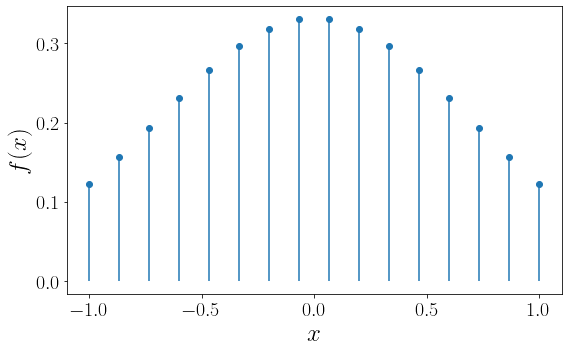

In [4]:
plt.figure(figsize=(8,5))
plt.scatter(x_values,amplitudes);
for q,i in enumerate(x_values):
    plt.vlines(i,ymin=0,ymax=amplitudes[q])
plt.xlabel(r'$x$',fontsize=25);
plt.ylabel(r'$f(x)$',fontsize=25);
plt.tick_params('both', labelsize=20);
plt.tight_layout()

In [5]:
# Define a PennyLane device
dev = qml.device("default.qubit", wires=n_qubits+1)

# Quantum circuit to encode the amplitudes
@qml.qnode(dev)
def prepare_state():
    qml.templates.MottonenStatePreparation(amplitudes, wires=range(n_qubits))
    return qml.state()

# Prepare the state
state = prepare_state()

# Output the state
print(f'Quantum state with encoded Gaussian function:\n\n  {state} \n\n Function probability:\n \n {amplitudes}')


Quantum state with encoded Gaussian function:

  [0.12198114+0.j 0.        +0.j 0.15645296+0.j 0.        +0.j
 0.19365703+0.j 0.        +0.j 0.23133491+0.j 0.        +0.j
 0.26669047+0.j 0.        +0.j 0.29671004+0.j 0.        +0.j
 0.31857773+0.j 0.        +0.j 0.33010871+0.j 0.        +0.j
 0.33010871+0.j 0.        +0.j 0.31857773+0.j 0.        +0.j
 0.29671004+0.j 0.        +0.j 0.26669047+0.j 0.        +0.j
 0.23133491+0.j 0.        +0.j 0.19365703+0.j 0.        +0.j
 0.15645296+0.j 0.        +0.j 0.12198114+0.j 0.        +0.j] 

 Function probability:
 
 [0.12198114 0.15645296 0.19365703 0.23133491 0.26669047 0.29671004
 0.31857773 0.33010871 0.33010871 0.31857773 0.29671004 0.26669047
 0.23133491 0.19365703 0.15645296 0.12198114]


In [6]:
# Define the oracle
def oracle():
    # Oracle implementation using controlled operations
    # This example assumes a simple phase flip 
    for i in range(n_qubits):
        qml.CNOT(wires=[i, n_qubits])

    # Apply a phase flip to the ancilla qubit
    qml.PauliZ(wires=n_qubits)

    for i in range(n_qubits):
        qml.CNOT(wires=[i, n_qubits])


In [7]:
# Iterative Quantum Amplitude Estimation (IQAE) setup
dev = qml.device("default.qubit", wires=n_qubits+1,shots=1000000)
@qml.qnode(dev)
def iqae_iteration(iter_=15):
    # Prepare the initial state
    qml.templates.MottonenStatePreparation(amplitudes, wires=range(n_qubits))
    for _ in range(iter_):
    # Apply the oracle
        oracle()

        # Apply the Grover diffusion operator
        qml.GroverOperator(wires=range(n_qubits))
        
    return qml.probs(wires=range(n_qubits))

# Execute the IQAE circuit
probs = iqae_iteration(int(np.sqrt(2**n_qubits)))


In [8]:
plt.figure(figsize=(9,6))
plt.scatter(x_values,amplitudes,label = 'True',s=8);
for q,i in enumerate(x_values):
    plt.vlines(i,ymin=0,ymax=amplitudes[q],alpha=0.9,linewidth=0.6)

# As the measurements are the amplitude squared, I plot the sqrt of the measurements    
plt.scatter(x_values,np.sqrt(probs),label='Measured');
#plt.yscale('log');
plt.legend(scatterpoints=30,fontsize=25);
plt.xlabel(r'$x$',fontsize=25);
plt.ylabel(r'$f(x)$',fontsize=25);
plt.tick_params('both', labelsize=20);

plt.tight_layout()

In [9]:
dev = qml.device("default.qubit", wires=n_qubits+1,shots=10000)
@qml.qnode(dev)
def circuit():
    qml.templates.MottonenStatePreparation(amplitudes, wires=range(n_qubits))
    for _ in range(int(np.sqrt(2**n_qubits))):
        oracle()
        qml.GroverOperator(wires=range(n_qubits))
        
    return qml.sample(wires=range(n_qubits))
result = circuit()
print(f'Integration result:   {np.sqrt(result).mean()}')    

Integration result:   0.498175


In [10]:
import vegas as V
integ = V.Integrator([-3.,3.])
result = integ(gaussian, nitn=10, neval=num_points)

In [11]:
print(result.summary())

itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   1.56(54)        1.56(54)            0.00     1.00
  2   1.56(52)        1.56(37)            0.00     1.00
  3   1.94(58)        1.67(31)            0.15     0.86
  4   0.79(44)        1.38(26)            0.99     0.40
  5   2.30(57)        1.53(23)            1.30     0.27
  6   1.66(46)        1.56(21)            1.05     0.39
  7   2.05(62)        1.61(20)            0.97     0.44
  8   1.09(47)        1.53(18)            0.98     0.44
  9   1.49(57)        1.53(17)            0.86     0.55
 10   2.20(58)        1.58(17)            0.89     0.53



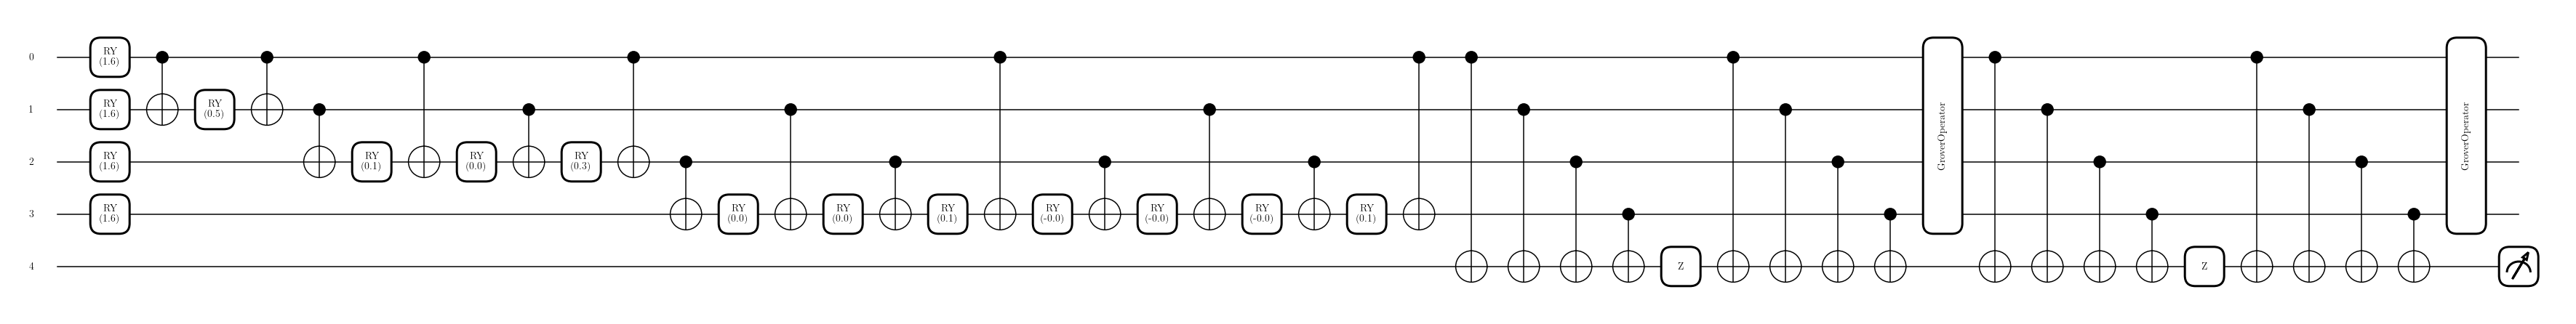

In [10]:
qml.draw_mpl(iqae_iteration,expansion_strategy='device',decimals=1,style='black_white')(2);


# Another Example: sin squared  function

In [49]:
# Number of qubits
n_qubits = 8
num_points = 2 ** n_qubits
upper_ = 5
lower_= -5
# Discretize the interval [-1, 1]
x_values = np.linspace(lower_,upper_, num_points)

# Define the Gaussian function
def gaussian(x):
    return np.sin(x)**2+ (3*np.cos(2*x)**2)/3

# Compute the Gaussian function values
f_values = gaussian(x_values)

# Normalize the function values to one  to create valid probability amplitudes
norm = np.sqrt(np.sum(f_values ** 2))
amplitudes = f_values / norm

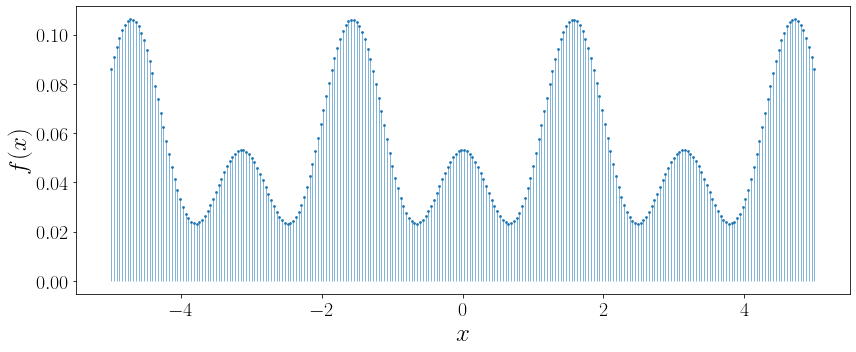

In [50]:
plt.figure(figsize=(12,5))
plt.scatter(x_values,amplitudes,s=3);
for q,i in enumerate(x_values):
    plt.vlines(i,ymin=0,ymax=amplitudes[q],alpha=0.9,linewidth=0.6)
plt.xlabel(r'$x$',fontsize=25);
plt.ylabel(r'$f(x)$',fontsize=25);
plt.tick_params('both', labelsize=20);
plt.tight_layout()

In [53]:
dev = qml.device("default.qubit", wires=n_qubits+1,shots=100000)
@qml.qnode(dev)
def iqae_iteration(iter_=2):
    # Prepare the initial state
    qml.templates.MottonenStatePreparation(amplitudes, wires=range(n_qubits))
    for _ in range(iter_):
    # Apply the oracle
        oracle()

        # Apply the Grover diffusion operator
        qml.GroverOperator(wires=range(n_qubits))

    return qml.probs(wires=range(n_qubits))

# Execute the IQAE circuit
probs = iqae_iteration(int(np.sqrt(2**n_qubits)))

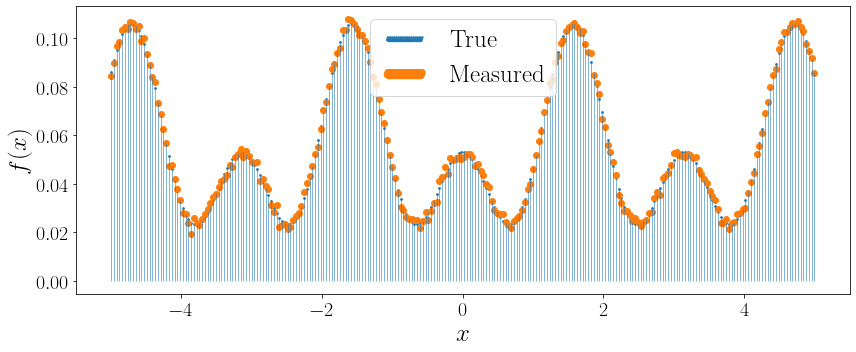

In [54]:
plt.figure(figsize=(12,5))
plt.scatter(x_values,amplitudes,s=3,label = 'True');
for q,i in enumerate(x_values):
    plt.vlines(i,ymin=0,ymax=amplitudes[q],alpha=0.9,linewidth=0.6)
plt.scatter(x_values,np.sqrt(probs),label='Measured');
plt.legend(scatterpoints=50,fontsize=25);
plt.xlabel(r'$x$',fontsize=25);
plt.ylabel(r'$f(x)$',fontsize=25);
plt.tick_params('both', labelsize=20);

plt.tight_layout()

In [55]:
dev = qml.device("default.qubit", wires=n_qubits+1,shots=10000)
@qml.qnode(dev)
def circuit():
    qml.templates.MottonenStatePreparation(amplitudes, wires=range(n_qubits))
    for _ in range(int(np.sqrt(2**n_qubits))):
        oracle()
        qml.GroverOperator(wires=range(n_qubits))
        
    return qml.probs(wires=range(n_qubits)) #qml.sample(wires=range(n_qubits))
result = circuit()
print(f'Integration result:   {(np.sqrt(result)*norm).sum()*(upper_-lower_)/len(amplitudes)}') 

Integration result:   10.495780440474762


In [56]:
import vegas as V
integ = V.Integrator([-5,5])
result = integ(gaussian, nitn=10, neval=100000)

In [57]:
print(result.summary())

itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   10.500241(12)   10.500241(12)       0.00     1.00
  2   10.500247(11)   10.5002441(82)      0.14     0.71
  3   10.500241(11)   10.5002430(66)      0.09     0.91
  4   10.500255(11)   10.5002460(57)      0.33     0.80
  5   10.500237(11)   10.5002442(51)      0.38     0.82
  6   10.500240(11)   10.5002435(46)      0.32     0.90
  7   10.500250(12)   10.5002444(43)      0.31     0.93
  8   10.500233(12)   10.5002430(40)      0.40     0.90
  9   10.500243(12)   10.5002430(38)      0.35     0.95
 10   10.500239(12)   10.5002427(36)      0.32     0.97



# Many things to check

* Still I have to read crefully the iterative amplitude estomation
* Is there any better orcale function to be used, may be a phase shift operator?
* This example affected by the right number of the used qubits. I belive there are many better methods to check
* The number of shots affects the computation
* For state prepration (data embeding) I used a simple technique, is this engouhg?
* An error mitigation algorithm to be used
* I don't know how to integrate the negative valued functions!! we need different embedding method

In [29]:
norm

tensor(10.23988676, requires_grad=True)